<a href="https://colab.research.google.com/github/hamzafarooq/multi-agent-course/blob/main/Module_4/Knowledge_Graphs/Knowledge_Graphs_Basic_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this notebook, we will build a knowledge graph-enhanced Retrieval-Augmented Generation (RAG) system using hotel reviews data. This represents a significant advancement over traditional RAG approaches that treat documents as isolated pieces of information.

Let's start by understanding the difference between traditional RAG and graph RAG:

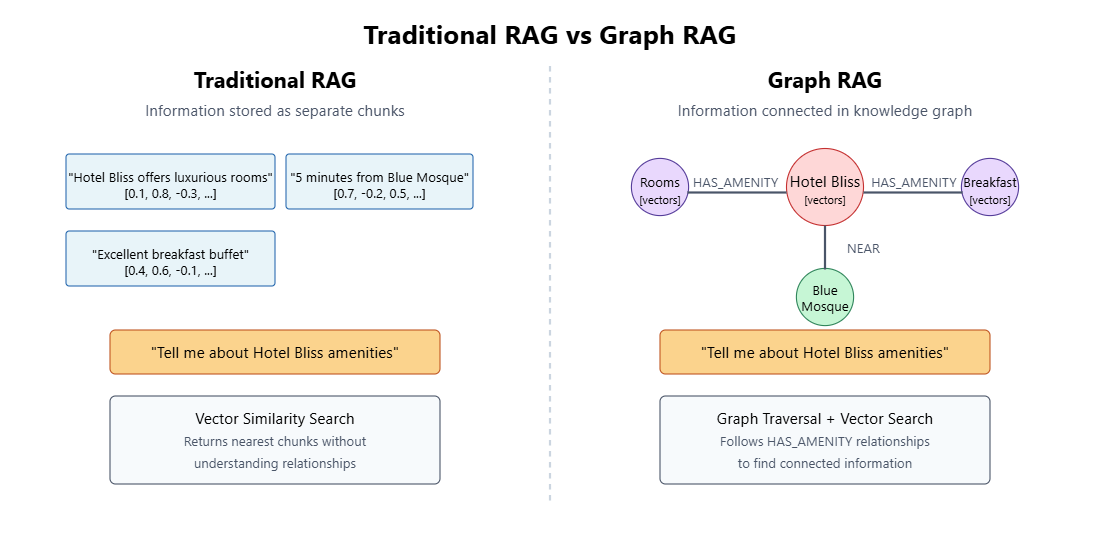

As we can see in the diagram above, traditional RAG treats each document as an isolated unit, while graph RAG captures the relationships between entities mentioned in the documents. This structural understanding enables more sophisticated querying and better answers.

## Architecture Overview
Our graph RAG system will have several key components:

architecture (1).svg

## Learning Outcomes
After completing the basic and advanced notebooks, you will be able to:

1. **Build Knowledge Graphs**
   - Construct graph representations from structured and unstructured data
   - Use NetworkX for graph manipulation and visualization
   - Migrate graphs to Neo4j for persistence and querying
   - Extract entities and relationships from text using LLMs
   
   Key skills: Graph modeling, entity extraction, relationship mapping

2. **Implement Graph RAG**
   - Create hybrid search combining vector and graph capabilities
   - Write graph queries using the Cypher query language
   - Build vector indices over graph nodes
   - Combine semantic search with graph traversal
   
   Key skills: Neo4j, Cypher, vector indexing, hybrid search strategies

3. **Evaluate RAG Approaches**
   - Compare traditional RAG vs graph RAG performance
   - Identify use cases where graph structure improves results
   - Measure and analyze query response quality
   - Debug and optimize graph RAG systems
   
   Key skills: RAG evaluation, performance analysis, system optimization

## Why Graph RAG Matters

Traditional RAG has several key limitations:
- Treats documents as independent chunks without understanding connections
- Cannot easily aggregate information across related items
- Limited ability to follow chains of reasoning
- Misses contextual relationships between entities

Graph RAG addresses these limitations by:
- Capturing explicit relationships between entities in a knowledge graph
- Enabling multi-hop reasoning by traversing relationships
- Combining semantic search with structural graph queries
- Supporting relationship-aware aggregation and pattern matching

For our hotel reviews example, this means we can:
- Connect hotels to their locations, amenities, and reviews
- Find patterns like "highly-rated hotels near specific landmarks"
- Aggregate sentiment across related entities
- Answer complex queries requiring multiple relationship hops
- Combine factual data with review sentiment analysis

## Prerequisites
- Basic understanding of Python and RAG concepts
- Familiarity with pandas for data manipulation
- Access to OpenAI API and Neo4j AuraDB (free tier)
- No prior knowledge of graph databases required

## What We'll Build
Following the architecture diagram above, this notebook will have us create a graph RAG system:
1. Constructs an initial knowledge graph from structured hotel data
3. Stores the graph in Neo4j
4. Implements graph search and retrieval methods on the graph for graph-based question-answering

Let's begin by examining our hotel reviews dataset and building our initial graph structure.

# Creating a Knowledge Graph from the Hotel Reviews Dataset

## Installation of Libraries

In [ ]:
%pip install pyvis IPython cchardet datasets==2.16.0 langchain neo4j openai tiktoken langchain-community langchain-experimental json-repair

## Data Setup

In [ ]:
from getpass import getpass
import os
from google.colab import userdata

if os.getenv("OPENAI_API_KEY") is None:
  try:
    os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
  # if this notebook is being run outside of the Colab UI or you just don't have the necessary secret set
  except (userdata.TimeoutException, userdata.SecretNotFoundError):
    if any(['VSCODE' in x for x in os.environ.keys()]):
      print('Please enter password in the VS Code prompt at the top of your VS Code window!')
    os.environ["OPENAI_API_KEY"] = getpass("")

assert os.getenv("OPENAI_API_KEY", "").startswith("sk-"), "This doesn't look like a valid OpenAI API key"
print("OpenAI API key configured")

In [ ]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("traversaal-ai-hackathon/hotel_datasets")

df=pd.DataFrame(dataset['train'])

In [ ]:
df.head(8)

## Strategy: Populating a KG programmatically from each record

In this section, we will get a handle on the "bare bones" of knowledge graph concepts - nodes, edges, and properties - by constructing our knowledge graph in memory, mirroring real-world development workflows. The NetworkX library suits us well for this: its Python-native API is beginner-friendly, it's a lightweight library that works nicely in a notebook environment, it provides us with faster iteration cycles of development and debugging than we would get in a database environment, and it allows us to focus on the structure of our emerging graph.  

Design considerations for this knowlede graph are follows:

1. From the original dataset, we identify 4 core entities (HOTEL, REVIEW, LOCALITY, & COUNTRY) and two derived entities (SENTIMENT of each review and TRIP_PERIOD, corresponding to the time of the original trip - a useful base for potential analysis of temporal patterns in the dataset).
2. Because of unescaped characters in some of the reviews, as well as the need to keep the KG complexity at manageable levels, we do some data pre-processing to clean the text and to condense the `tripdate` column values into seasonal buckets in a `trip_period` column.
3. Nodes are colored as follows:
 - Hotel: blue
 - Review: orange
 - Trip period: magenta
 - Sentiment: purple
 - Locality: red
 - Country: green


In [ ]:
# @title Data pre-processing (optional reading)

import re
from textblob import TextBlob
import numpy as np

df['review_text'] = df['review_text'].str.replace('$', '\$', regex=True)

df['review_title'] = df['review_title'].str.replace('$', '\$', regex=True)

month_to_season = {
    'January': 'Winter',
    'February': 'Winter',
    'March': 'Spring',
    'April': 'Spring',
    'May': 'Spring',
    'June': 'Summer',
    'July': 'Summer',
    'August': 'Summer',
    'September': 'Fall',
    'October': 'Fall',
    'November': 'Fall',
    'December': 'Winter'
}

# Condense the many distinct date values from "Month Year" to "Season Year"
def convert_to_season_year(month_year_str: str):
    month = month_year_str.split()[0] if ' ' in month_year_str else ''

    if month in month_to_season:
        season = month_to_season[month]
        year = month_year_str.split()[1]
        return f"{season} {year}"

    else:
      return 'Unknown'

# Simple sentiment analysis
def get_sentiment(text):
    if text is None:
        return np.nan
    return TextBlob(text).sentiment.polarity



df['trip_period'] = df['tripdate'].apply(convert_to_season_year)
df['sentiment'] = df['review_text'].apply(get_sentiment)

# Transforming price_range from Google Maps-esque dollar sign scale to a numeric scale
df['price_range'] = df['price_range'].str.count('\$')
df['price_range'] = df['price_range'].astype(int)

In [ ]:
# @title Knowledge Graph Builder & Visualizer

import pandas as pd
import networkx as nx
from pyvis.network import Network
from IPython.display import IFrame
from IPython.display import Markdown, HTML


colors = {
    'HOTEL': 'lightblue',
    'REVIEW': 'orange',
    'LOCALITY': 'red',
    'COUNTRY': 'green',
    'TRIP_DATE': 'magenta',
    'SENTIMENT': 'purple',
}
sizes = {
    'HOTEL': 20,
    'REVIEW': 15,
    'LOCALITY': 25,
    'COUNTRY': 30,
    'TRIP_DATE': 10,
    'SENTIMENT': 15,
}


# Initialize a directed graph
G = nx.DiGraph()

# Adding nodes with the entity type as a node attribute
for index, row in df.iterrows():
    if row['hotel_name'] not in G:
      G.add_node(row['hotel_name'],
                 entity='HOTEL',
                 description=row['hotel_description'],
                 url=row['hotel_url'],
                 image=row['hotel_image'],
                 address=row['street_address'],
                 price_range=row['price_range'],
                 locality=row['locality'],
                 color=colors.get('HOTEL', 'gray'),
                 size=sizes.get('HOTEL', 10), )
    if row['locality'] not in G:
      G.add_node(row['locality'], entity='LOCALITY', color=colors.get('LOCALITY', 'gray'),
                 size=sizes.get('LOCALITY', 10))

    if row['country'] not in G:
      G.add_node(row['country'], entity='COUNTRY', color=colors.get('COUNTRY', 'gray'),
                 size=sizes.get('COUNTRY', 10))

    if row['trip_period'] != None and row['trip_period'] not in G:
        G.add_node(row['trip_period'], entity='TRIP_DATE', color=colors['TRIP_DATE'], size=sizes['TRIP_DATE'])

    if not G.has_edge(row['hotel_name'], row['locality']):
      G.add_edge(row['hotel_name'], row['locality'], relationship='LOCATED_IN', color='red')

    if not G.has_edge(row['locality'], row['country']):
      G.add_edge(row['locality'], row['country'], relationship='LOCATED_IN', color='red')


    G.add_node(
               row['review_title'],
               entity='REVIEW',
               text=row['review_text'],
               tripdate=row['trip_period'],
               rating_value=row['rating_value'],
               color=colors.get('REVIEW', 'gray'),
               size=sizes.get('REVIEW', 10))
    # Adding edges to denote relationships
    G.add_edge(row['hotel_name'], row['review_title'], relationship='HAS_REVIEW')
    if row['trip_period'] != None:
      G.add_edge(row['review_title'], row['trip_period'], relationship='ON_DATE')

    # Add sentiment
    sentiment = 'Positive' if row['sentiment'] > 0 else 'Negative' if row['sentiment'] < 0 else 'Neutral'
    if sentiment not in G:
        G.add_node(sentiment, entity='SENTIMENT', color=colors.get('SENTIMENT', 'gray'), size=sizes.get('SENTIMENT', 10))
    G.add_edge(row['review_title'], sentiment, relationship='HAS_SENTIMENT')


# Step 4: Visualization (Optional)
# Convert to a pyvis network
nt = Network('700px', '700px', notebook=True, cdn_resources='in_line')
# if you are not in a Jupyter environment, you might need to set notebook=False
nt.from_nx(G)
nt.toggle_physics(True)  # Enable force-directed algorithm
nt.save_graph('hotel_reviews_graph.html')
nt.show('hotel_reviews_graph.html')

HTML('hotel_reviews_graph.html')


# From In-Memory to Persistent Graph Storage: Why We Need Neo4j

While we've successfully built our knowledge graph in memory using NetworkX, we're approaching limitations that indicate we need a more robust solution. Let's understand why:

## Limitations of In-Memory Graphs

1. **Persistence & Scalability**
   - Our NetworkX graph exists only in RAM and disappears when our program ends
   - Performance degrades with large graphs due to memory limitations

2. **Query Capabilities**
   - Basic traversal operations only, no built-in query optimization
   - Complex queries require custom implementation
   - **No vector similarity search support**

## Enter Neo4j: A Graph Database Solution

Neo4j addresses these limitations by providing:

1. **Persistent Storage**
   - Durable storage with ACID compliance
   - Survives program restarts

2. **Scalable Architecture**
   - Efficient disk-based storage and index-backed querying
   - Handles billions of nodes/relationships

3. **Advanced Querying**
   - Cypher query language with built-in optimization
   - Pattern matching, aggregations, and vector similarity search integration

4. **Production Features**
   - Multi-user access, backup/recovery, security controls
  
## Why This Matters for Our Hotel Reviews Graph

Our knowledge graph will benefit from Neo4j's:

1. **Vector Search Integration** - Combine semantic search with graph traversal for hybrid strategies

2. **Complex Querying** - Find patterns like "hotels near landmarks with good reviews" and aggregate data across relationship types

3. **Future Growth** - Add more data without performance impact and enable concurrent access


Let's migrate our NetworkX graph to Neo4j to unlock these capabilities...

# Neo4j Database Setup


Go to https://neo4j.com/cloud/platform/aura-graph-database/ and sign up for a free account. We will use that account to create an instance of the free Aura database service and load our knowledge graph into it. (Provisioning the DB will take a few minutes)
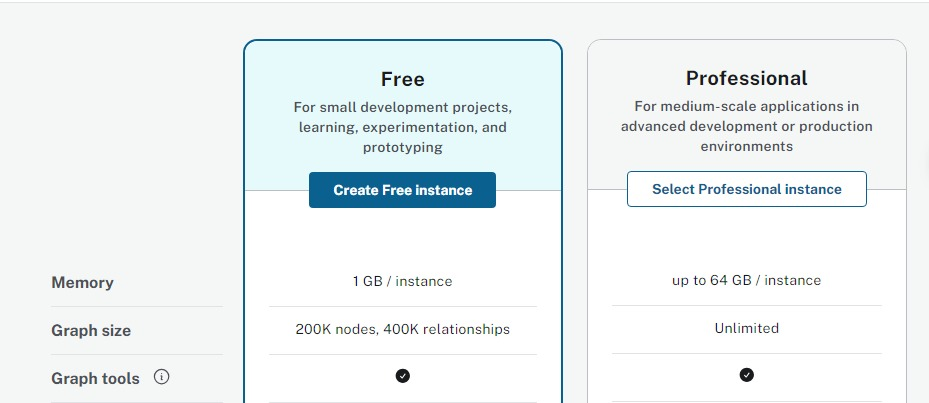

After you select "Create Free Instance" on the above screen, you'll be shown a modal window with your credentials to connect to the new instance. Copy them down to a safe place (or click "Download and continue") and enter them into the cell below.

In [ ]:
from neo4j import GraphDatabase
from google.colab import userdata

url = userdata.get('NEO4J_URI')
username ="neo4j"
password = userdata.get('NEO4J_PASSWORD')

driver = GraphDatabase.driver(url, auth=(username, password))

### Ingest the data into Neo4j

Below, we iterate through all the nodes and relationships in our in-memory NetworkX graph and upload them to Neo4j.

Note that for our nodes, we give them a base label we call `__Entity__` as well as their individual type from the above taxonomy. We have lifted this design choice from the [Neo4jGraph source code](https://api.python.langchain.com/en/latest/_modules/langchain_community/graphs/neo4j_graph.html#Neo4jGraph.add_graph_documents) that Neo4j contributed to Langchain. Later, when we create a vector index for the graph in the advanced notebook, this allows us to more efficiently index all the nodes together for vector search.

In [ ]:
def add_graph_to_neo4j(driver, graph):
    with driver.session() as session:
        # Add Nodes
        for node, attrs in graph.nodes(data=True):
            cypher_query = """
            MERGE (n:{label}{{name: $name, entity: $entity}})
            SET n += $props
            WITH n
            CALL apoc.create.addLabels( n, ['__Entity__'] ) YIELD node
            RETURN distinct 'done' AS result
            """.format(label=attrs['entity'])  # Dynamically set the label based on the 'entity' attribute
            session.run(cypher_query, name=node, entity=attrs['entity'], props={k: v for k, v in attrs.items() if k not in ['entity']})

        # Add Edges
        for source, target, attrs in graph.edges(data=True):
            cypher_query = """
            MATCH (a),(b)
            WHERE a.name = $source AND b.name = $target
            MERGE (a)-[r:{relationship}]->(b)
            SET r += $props
            """.format(relationship=attrs['relationship'])  # Dynamically set the relationship type
            session.run(cypher_query, source=source, target=target, props={k: v for k, v in attrs.items() if k not in ['relationship']})

# Finally, call the function to add your graph to Neo4j
add_graph_to_neo4j(driver, G)


In [ ]:
G.number_of_nodes()

# Querying the knowledge graph RAG

In [ ]:
from langchain.chains import GraphCypherQAChain
from langchain.graphs import Neo4jGraph
from langchain.chat_models import ChatOpenAI

graph = Neo4jGraph(
    url=url,
    username=username,
    password=password,
    enhanced_schema=True
)

graph.refresh_schema()

cypher_chain = GraphCypherQAChain.from_llm(
    cypher_llm = ChatOpenAI(temperature=0, model_name='gpt-4o-mini'),
    qa_llm = ChatOpenAI(temperature=0),
    graph=graph,
    verbose=True,
    allow_dangerous_requests=True
)

The graph RAG can run logical operators on the data:

In [ ]:
cypher_chain.run(
    "How many reviews does the Romance Istanbul Hotel have?"
)

In [ ]:
cypher_chain.run(
    "Which hotel has the most reviews?"
)

The graph RAG can answer questions that require reasoning over multiple "hops" of relationships (though you should focus here on the **context retrieved**, not the answer generated - the latter is a different, prompt engineering problem in the Langchain and not relevant to our current scope):

In [ ]:
cypher_chain.run(
    "What positive things were said in reviews for hotels in San Francisco where the reviewer's trip date occurred in Fall 2023?"
)

## Understanding Retrieval Strategies in Graph RAG

In the preceding section, the GraphCypherQAChain showed us how we can leverage our knowledge graph to answer complex questions that require logical operations and multi-hop reasoning. This demonstrates the power of graph-based retrieval for RAG systems.

### From Black Box to Implementation

While the GraphCypherQAChain provides impressive capabilities, it's important to understand what's happening under the hood (which is why you are enrolled in this class). At the core of any Graph RAG system is the **retrieval step** (the **R** in RAG) - the process of converting a natural language question into a structured graph query that can extract relevant information.

Several design patterns exist for handling this critical step, each with different trade-offs:

1. **Text2Cypher**: The approach used by GraphCypherQAChain, where an LLM generates a complete Cypher query from scratch based on the graph schema. While flexible and able to handle novel queries, this approach can be complex, hard to debug, and sometimes produces suboptimal queries.

2. **Basic Retrieval**: The most simple approach, comprised of just a vector similarity search on nodes or text chunks to return the top k most similar ones.

3. **Cypher Templates**: A middle-ground that uses parameterized query templates. It is essentially stored-procedure-oriented programming, but the benefit to it is that intricate logic can be encoded into the retrieval queries and there is almost no opportunity for the LLM to go offtrack. The LLM's job is only to extract entities from the question and map them to template parameters.

A reference catalog of other retriever patterns, maintained as a commmunity resource by Neo4j, can be found at [graphrag.com](https://graphrag.com/concepts/intro-to-graphrag/).

For the remainder of this notebook, we'll implement a **Cypher template-based** retriever from scratch. This approach offers a good balance between flexibility and reliability, while giving you insight into how retrieval systems work without the abstraction of complex frameworks.

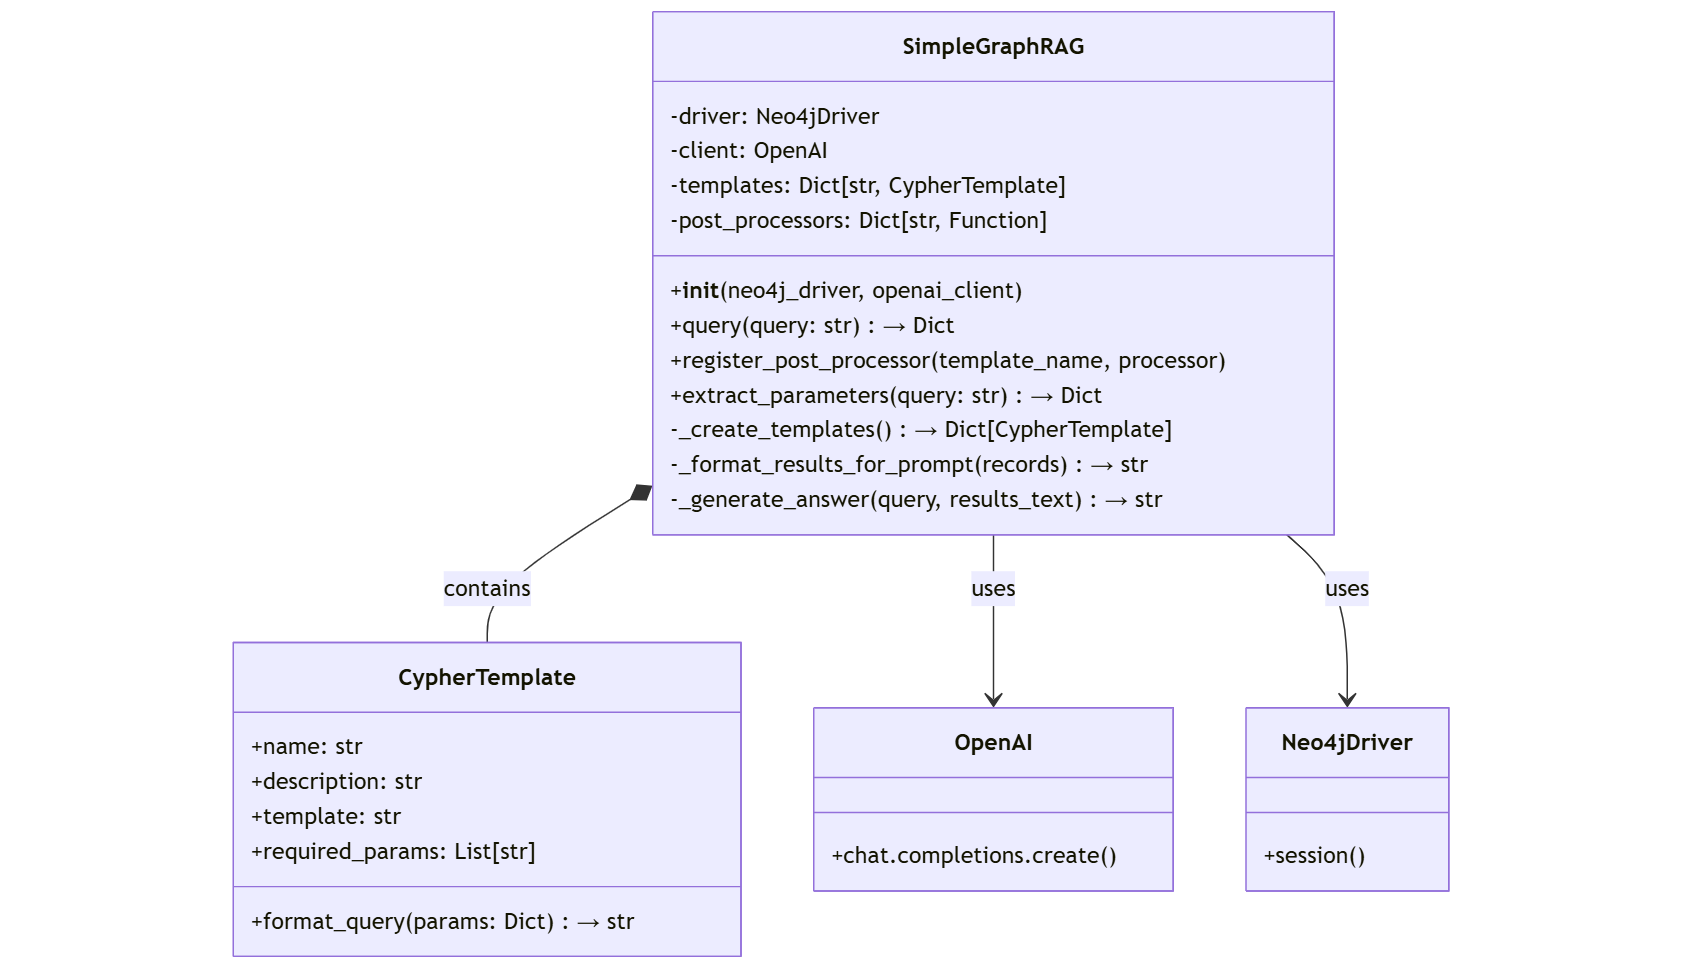

```
┌─────────────────────────────────────────────────────────────────────────────┐
│                           SimpleGraphRAG Pipeline                          │
└─────────────────────────────────────────────────────────────────────────────┘

INPUT STAGE                 EXECUTION STAGE              OUTPUT STAGE
┌─────────────┐            ┌─────────────────────────┐    ┌──────────────────┐
│ User Query  │            │                         │    │                  │
│    ↓        │            │ ┌─────────────────────┐ │    │ ┌──────────────┐ │
│ Extract     │ ─────────→ │ │ Select Template     │ │    │ │ Raw Results  │ │
│ Parameters  │            │ │        ↓            │ │    │ │      ↓       │ │
│    ↓        │            │ │ Format Cypher       │ │ ──→│ │ Post-process │ │
│ OpenAI      │            │ │        ↓            │ │    │ │      ↓       │ │
│ Function    │            │ │ Execute Query       │ │    │ │ Generate     │ │
│ Call        │            │ │        ↓            │ │    │ │ Answer       │ │
│             │            │ │ Neo4j Database      │ │    │ │      ↓       │ │
└─────────────┘            │ └─────────────────────┘ │    │ │ OpenAI Call  │ │
                           └─────────────────────────┘    │ │      ↓       │ │
                                                          │ │ Final        │ │
                                                          │ │ Response     │ │
                                                          │ └──────────────┘ │
                                                          └──────────────────┘
```
### Key Components:
- **CypherTemplate**: Contains 3 pre-built query templates (hotel_info, hotels_by_location, hotel_reviews)
- **Neo4j Driver**: Executes Cypher queries against the knowledge graph
- **OpenAI Client**: Used twice - parameter extraction and answer generation
- **Post-processors:** Optional formatting functions registered per template


In [ ]:
import os
from typing import List, Dict, Any, Optional, Tuple
from openai import OpenAI
import json
from neo4j import GraphDatabase
from dataclasses import dataclass

@dataclass
class CypherTemplate:
    """A template for a Cypher query with named parameters."""
    name: str
    description: str
    template: str
    required_params: List[str]

    def format_query(self, params: Dict[str, Any]) -> str:
        """Format the template with the provided parameters."""
        return self.template.format(**params)

In [ ]:
class SimpleGraphRAG:
    """
    A streamlined Graph RAG implementation using function calling for entity extraction.
    """

    def __init__(self, neo4j_driver: GraphDatabase.driver, openai_client: OpenAI):
        self.driver = neo4j_driver
        self.client = openai_client
        self.templates = self._create_templates()
        self.post_processors = {}

    def _create_templates(self) -> Dict[str, CypherTemplate]:
        """Create a dictionary of query templates."""
        templates = {}

        # Hotel information by name
        templates["hotel_info"] = CypherTemplate(
            name="hotel_info",
            description="Get detailed information about a specific hotel by name",
            required_params=["hotel_name"],
            template="""
            MATCH (h:HOTEL {{name: '{hotel_name}'}})
            OPTIONAL MATCH (h)-[:HAS_REVIEW]->(r:REVIEW)
            OPTIONAL MATCH (h)-[:LOCATED_IN]->(l:LOCALITY)
            OPTIONAL MATCH (h)-[:HAS_AMENITY]->(a:AMENITY)
            RETURN h.name as hotel_name,
                   h.description as description,
                   h.price_range as price_range,
                   l.name as location,
                   collect(distinct a.name) as amenities,
                   avg(r.rating_value) as average_rating,
                   count(r) as review_count
            """
        )

        # Hotels in a specific location
        templates["hotels_by_location"] = CypherTemplate(
            name="hotels_by_location",
            description="Find hotels in a specific location",
            required_params=["location_name"],
            template="""
            MATCH (l:LOCALITY {{name: '{location_name}'}})<-[:LOCATED_IN]-(h:HOTEL)
            OPTIONAL MATCH (h)-[:HAS_REVIEW]->(r:REVIEW)
            RETURN h.name as hotel_name,
                   h.price_range as price_range,
                   avg(r.rating_value) as average_rating,
                   count(r) as review_count
            ORDER BY average_rating DESC
            """
        )

        # Reviews for a specific hotel
        templates["hotel_reviews"] = CypherTemplate(
            name="hotel_reviews",
            description="Get reviews for a specific hotel",
            required_params=["hotel_name"],
            template="""
            MATCH (h:HOTEL {{name: '{hotel_name}'}})-[:HAS_REVIEW]->(r:REVIEW)
            OPTIONAL MATCH (r)-[:HAS_SENTIMENT]->(s:SENTIMENT)
            OPTIONAL MATCH (r)-[:ON_DATE]->(d:TRIP_DATE)
            RETURN r.title as review_title,
                   r.text as review_text,
                   r.rating_value as rating,
                   s.name as sentiment,
                   d.name as trip_date
            ORDER BY r.rating_value DESC
            LIMIT 10
            """
        )

        return templates

    def register_post_processor(self, template_name: str, processor):
        """Register a post-processing function for a specific template."""
        self.post_processors[template_name] = processor

    def extract_parameters(self, query: str) -> Dict[str, Any]:
        """
        Extract query parameters using OpenAI function calling.
        """
        # Define the function schema
        function_schema = {
            "name": "extract_hotel_query_parameters",
            "description": "Extract parameters from a natural language query about hotels",
            "parameters": {
                "type": "object",
                "properties": {
                    "query_type": {
                        "type": "string",
                        "enum": list(self.templates.keys()),
                        "description": "The type of query being asked"
                    },
                    "hotel_name": {
                        "type": "string",
                        "description": "Name of a specific hotel mentioned in the query"
                    },
                    "location_name": {
                        "type": "string",
                        "description": "Name of a location (city, neighborhood, etc.) mentioned in the query"
                    }
                },
                "required": ["query_type"]
            }
        }

        # Use the function calling schema to call the OpenAI API
        response = self.client.chat.completions.create(
            model="gpt-4o-mini",  # or your preferred model
            temperature=0.1,
            messages=[{"role": "user", "content": query}],
            functions=[function_schema],
            function_call={"name": "extract_hotel_query_parameters"}
        )

        # Extract parameters from the function call
        function_call = response.choices[0].message.function_call
        if function_call and function_call.name == "extract_hotel_query_parameters":
            try:
                return json.loads(function_call.arguments)
            except json.JSONDecodeError:
                print(f"Error parsing function call arguments: {function_call.arguments}")

        return {"query_type": None}

    def query(self, query: str) -> Dict[str, Any]:
        """
        Process a natural language query and generate a response.
        """

        parameters = self.extract_parameters(query)
        query_type = parameters.get("query_type")

        # Check if we have a matching template
        if not query_type or query_type not in self.templates:
            return {
                "status": "error",
                "message": "Could not determine query type",
                "query": query
            }

        template = self.templates[query_type]

        # Check for required parameters
        missing_params = [p for p in template.required_params if p not in parameters]
        if missing_params:
            return {
                "status": "error",
                "message": f"Missing required parameters: {missing_params}",
                "query": query
            }

        # Format and execute query
        try:
            cypher_query = template.format_query(parameters)
            with self.driver.session() as session:
                result = session.run(cypher_query)
                records = [dict(record) for record in result]
        except Exception as e:
            return {
                "status": "error",
                "message": f"Error executing query: {str(e)}",
                "query": query
            }

        # Apply post-processing if available
        if query_type in self.post_processors:
            records = self.post_processors[query_type](records)

        # Generate answer
        result_text = self._format_results_for_prompt(records)
        answer = self._generate_answer(query, result_text)

        return {
            "status": "success",
            "query": query,
            "template_used": query_type,
            "parameters": parameters,
            "cypher_query": cypher_query,
            "results": records,
            "answer": answer
        }

    def _format_results_for_prompt(self, records: List[Dict[str, Any]]) -> str:
        """Format results for inclusion in the answer generation prompt."""
        if not records:
            return "No results were found for this query."

        # Simple formatting for demonstration
        items = []
        for i, item in enumerate(records):
            item_str = f"Result {i+1}:\n"
            for k, v in item.items():
                if isinstance(v, (list, set)):
                    v_str = ", ".join(str(x) for x in v if x is not None)
                    item_str += f"  {k}: {v_str}\n"
                else:
                    item_str += f"  {k}: {v}\n"
            items.append(item_str)

        return "\n".join(items)

    def _generate_answer(self, query: str, results_text: str) -> str:
        """Generate a natural language answer using the query and results."""
        prompt = f"""
The user asked: "{query}"

I retrieved the following information from the graph database:
{results_text}

Based on this information, provide a helpful, conversational response to the user's query.
Make sure to address all aspects of their question if possible.
If the information retrieved doesn't fully answer their query, acknowledge this limitation.
"""

        response = self.client.chat.completions.create(
            model="gpt-4o-mini",
            temperature=0.7,
            messages=[
                {"role": "system", "content": "You are a helpful hotel recommendation assistant that provides accurate information based on a knowledge graph of hotel data."},
                {"role": "user", "content": prompt}
            ]
        )

        return response.choices[0].message.content



## Running the Graph RAG process

In [ ]:
def run_demo():
    """Run a demonstration of the SimpleGraphRAG system."""
    # Setup connections
    openai_client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

    neo4j_driver = GraphDatabase.driver(
        userdata.get("NEO4J_URI"),
        auth=("neo4j",
              userdata.get("NEO4J_PASSWORD"))
    )

    # Initialize the system
    graph_rag = SimpleGraphRAG(
        neo4j_driver=neo4j_driver,
        openai_client=openai_client
    )

    # Register a simple post-processor
    def format_ratings(results):
        for result in results:
            if 'average_rating' in result and result['average_rating'] is not None:
                result['average_rating'] = round(result['average_rating'], 1)
        return results

    graph_rag.register_post_processor("hotel_info", format_ratings)
    graph_rag.register_post_processor("hotels_by_location", format_ratings)

    # Test queries
    test_queries = [
        "Tell me about the Romance Istanbul Hotel",
        "What hotels are in San Francisco?",
        "What do the reviews say about the Grant Plaza Hotel?"
    ]

    for query in test_queries:
        print(f"\n\n===== Query: {query} =====")
        result = graph_rag.query(query)

        if result["status"] == "success":
            print(f"Template used: {result['template_used']}")
            print(f"Parameters extracted: {result['parameters']}")
            print(f"Cypher query: {result['cypher_query']}")
            print("\nAnswer:")
            print(result["answer"])
        else:
            print(f"Error: {result['message']}")


In [ ]:
run_demo()